In [1]:
from omegaconf import OmegaConf
import numpy as np
import pickle as pkl
import torch
import sys
sys.path.append("/dreambig/qingyi/stable-diffusion")

# from dataloader import image_loader
# from ldm.data.satellite import SatelliteTrain, SatelliteValidation
# from main import DataModuleFromConfig
from ldm.util import instantiate_from_config

from setup import *
from scripts.img2img import load_model_from_config

%load_ext autoreload
%autoreload 2

torch.multiprocessing.set_sharing_strategy('file_system')

In [2]:
version = '2023-07-01T00-44-09'
epoch = 60
epoch = f"{epoch:06d}"

ckpt = '/dreambig/qingyi/stable-diffusion/logs/'+version+'_sae_kl_8x8x64/checkpoints/epoch='+epoch+'.ckpt'

model_config = OmegaConf.load('/dreambig/qingyi/stable-diffusion/logs/'+version+'_sae_kl_8x8x64/configs/'+version+'-project.yaml')
data_config = OmegaConf.load('/dreambig/qingyi/stable-diffusion/configs/autoencoder/sae_kl_8x8x64.yaml')
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
model = load_model_from_config(model_config, ckpt, verbose=True, device=1)


Loading model from /dreambig/qingyi/stable-diffusion/logs/2023-07-01T00-44-09_sae_kl_8x8x64/checkpoints/epoch=000060.ckpt
Global Step: 217953
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 64, 8, 8) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [3]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 125836751


In [3]:
data = instantiate_from_config(data_config.data)
data.prepare_data()
data.setup()

train_loader = data._train_dataloader()
test_loader = data._val_dataloader()

In [ ]:
ct = []
encoder_output = []
im = []
sup_true_list = []
sup_list = []

for step, batch in enumerate(test_loader):
    
    inputs, sup_true = model.get_input(batch, 'image', 'condition')
    inputs = inputs.to(device)
    _, posterior, sup = model(inputs)
    
    encoder_output += [posterior.mode().cpu().detach().numpy()]
    ct += [s[s.rindex("/")+1: s.rindex("_")] for s in batch['image_path']]
    im += batch['image_path']
    sup_true_list += [sup_true.cpu().detach().numpy()]
    sup_list += [sup.cpu().detach().numpy()]
    
    if step % 100 == 0:
        print(step, end='\t')
        
for step, batch in enumerate(train_loader):
    
    inputs, sup_true = model.get_input(batch, 'image', 'condition')
    inputs = inputs.to(device)
    _, posterior, sup = model(inputs)
    
    encoder_output += [posterior.mode().cpu().detach().numpy()]
    ct += [s[s.rindex("/")+1: s.rindex("_")] for s in batch['image_path']]
    im += batch['image_path']
    sup_true_list += [sup_true.cpu().detach().numpy()]
    sup_list += [sup.cpu().detach().numpy()]
 
    if step % 100 == 0:
        print(step, end='\t')
        

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [393216], which does not match the required output shape [2, 256, 256, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [20], which does not match the required output shape [2, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

0	100	200	300	400	500	600	700	800	900	1000	1100	1200	1300	1400	

In [ ]:
encoder_output = np.vstack(encoder_output)  

In [ ]:
encoder_output.shape

In [ ]:
print(version+"_sae_kl_f32_ep"+epoch.lstrip('0')+".pkl")

In [ ]:
with open(proj_dir+"latent_space/"+version+"_sae_kl_f32_ep"+epoch.lstrip('0')+".pkl", "wb") as f:

    pkl.dump(encoder_output, f)
    pkl.dump(im, f)
    pkl.dump(ct, f)
    pkl.dump(sup_true_list, f)
    pkl.dump(sup_list, f)

In [34]:
# with open(proj_dir+"latent_space/2023-06-27T20-57-11_sae_kl_f32_ep10.pkl", "rb") as f:
#     pkl.load(f)
#     pkl.load(f)
#     pkl.load(f)
#     sup_true_list = pkl.load(f)
#     sup_list = pkl.load(f)
    

In [9]:
sup_true_list = np.concatenate(sup_true_list)
sup_list = np.concatenate(sup_list)

sup_true_list = sup_true_list[:3176]
sup_list = sup_list[:3176]

In [10]:
from sklearn.metrics import r2_score

r2 = r2_score(sup_true_list, sup_list, multioutput='raw_values')

In [11]:
xlabels = ['pop density','pct25-34yrs','pct35-50yrs','pct over65yrs',
                 'pct white','pct non-white','pct black',
                 'pct col grad','avg tt to work','income']

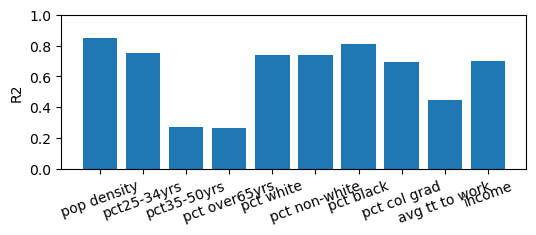

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,2))
ax.bar(x = np.arange(10), height=r2)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, rotation=20);
ax.set_ylim([0,1])
ax.set_ylabel('R2')
fig.savefig(out_dir+"SVAE/"+version+"_sae_kl_f32_"+
            str(model_config['model']['params']['lossconfig']['params']['supervision_factor'])+
            "_ep"+epoch.lstrip('0')+".png", bbox_inches='tight')

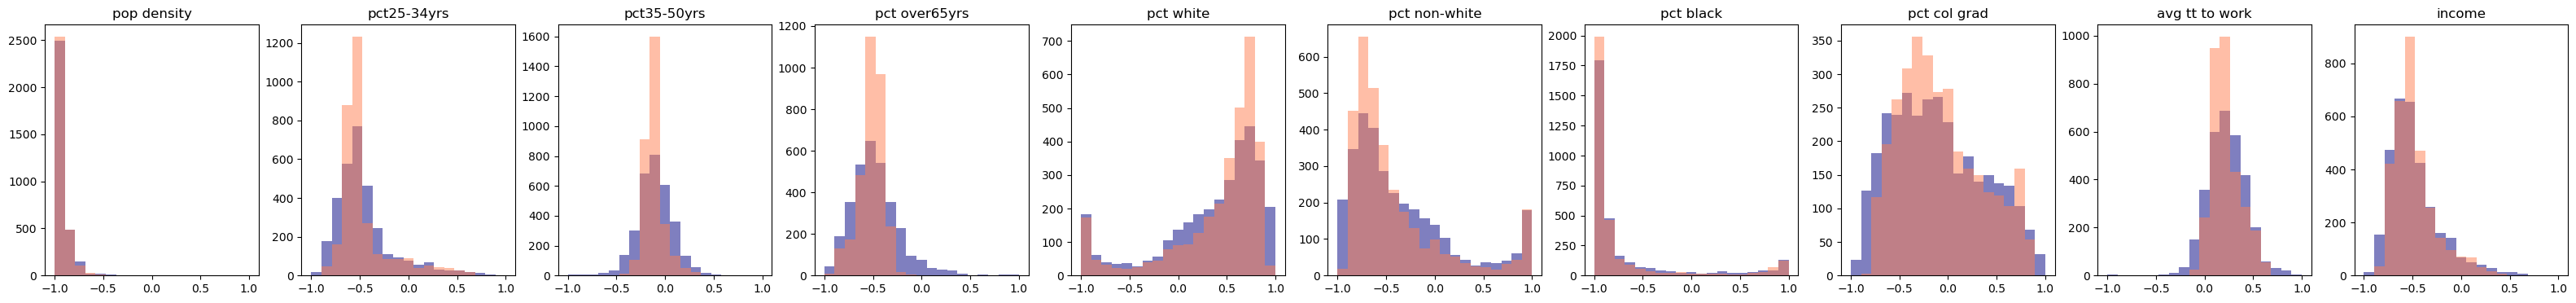

In [38]:
fig, ax = plt.subplots(1,10, figsize=(40,4))
for i,j,c in zip(np.arange(10), np.arange(10), xlabels):
    ax[i].hist(sup_true_list[:,j], bins=np.linspace(-1,1,20), alpha=0.5, color='navy')
    ax[i].hist(sup_list[:,j], bins=np.linspace(-1,1,20), alpha=0.5, color='coral')
    ax[i].set_title(c)